# Fudan RPML Assignment1: Machine Learning Meets Fashion

![Machine Learning Meets Fashion](./img/ml_meets_fashion.jpg)

*Your name and Student ID: [Name], [Student ID]*

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

In this assignment, you will use what you have learned to tackle some pratical problems. Fashion MNIST dataset[1] is the MNIST-like fashion product database for image classification you will play with this time. It originally consists of a training set of 60000 examples and a test set of 10000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

To make this task more realistic, we selected 14600 labeled examples from the training set and did a little processing. You have to do this image classifictaion task with our new dataset. 

You have to impletement several standard classification methods in the './fudanPRML' folder:
- K-nearest Neighbor (15 points)
- Softmax (15 points)
- Neural Network (30 points)    

and then do your exploration (30 points).

You can only use some basic python libraries in your experiment like numpy, paddle(without using the paddle.nn), matplotlib and so on. And please write down the version with them in the './requirements.txt' file.

## 1. Setup

In [1]:
# setup code
%load_ext autoreload
%autoreload 2
# 当导入了自己写的python模块时，在ipynb文件里import一次之后，即使修改了的python模块，重新运行import其实还是用的之前的python模块
# 因为已经将该模块在第一次导入时存在了内存里，第二次import没效果，这时需要重启kenel才能导入修改过的python模块。
# 此处首先自动加载导入的python模块，保证你每次在ipynb里使用的模块是最新版本，所以在你修改了模块代码之后，不需要重新刷新你的kenel。


In [2]:
import paddle
%matplotlib inline
from matplotlib import pyplot as plt

paddle.device.get_device()
paddle.set_device(paddle.device.get_device())

Place(cpu)

In [4]:
import numpy as np
import paddle
dataset_path = './dataset'

X_train = np.load(dataset_path + '/X_train.npy')
y_train = np.load(dataset_path + '/y_train.npy')
X_test = np.load(dataset_path + '/X_test.npy')
y_test = np.load(dataset_path + '/y_test.npy')

is_shuffle = True
if is_shuffle:
    idx = paddle.randperm(X_train.shape[0])
    X_train = X_train[idx]
    y_train = y_train[idx]

In [7]:
label_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

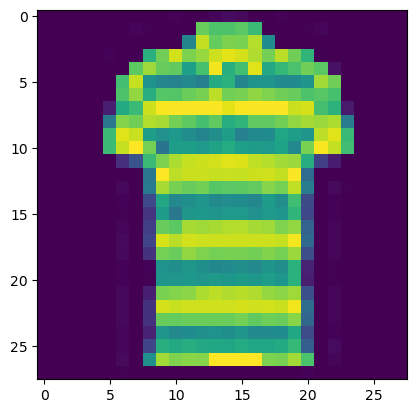

In [18]:
%matplotlib inline
# 可以将matplotlib的图表直接嵌入到Notebook之中，或者使用指定的界面库显示图表
from matplotlib import pyplot as plt

plt.imshow(X_train[0].reshape(28,28))

## 2. Exploratory Data Analysis (5 points)

Your may have to explore the dataset and do some analysis first.

训练集中各类别条目数量:
 [6000, 4000, 1000, 1000, 1000, 1000, 200, 200, 100, 100]
观察可知存在类别不均衡的问题


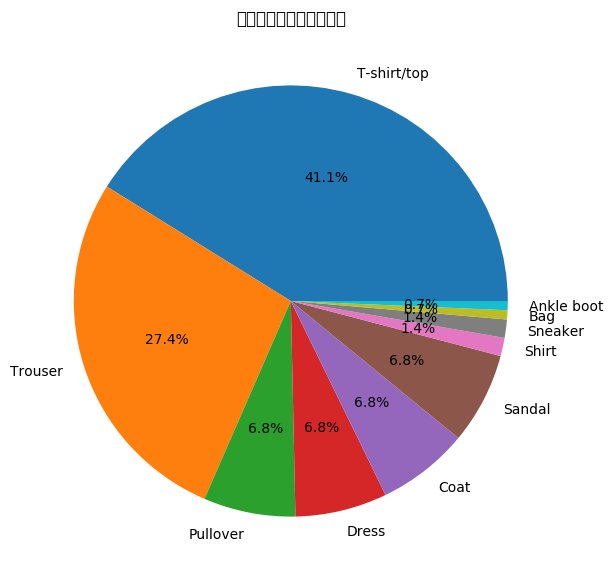

In [8]:
label_summary = [0 for i in range(10)]
for label in y_train:
    label_summary[label] = label_summary[label] + 1
print('训练集中各类别条目数量:\n',label_summary)
print('观察可知存在类别不均衡的问题')
plt.figure(figsize=(7,7))
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  #指定字体为雅黑，解决文字乱码问题
plt.title('训练集中各类别条目占比')
plt.pie(label_summary,labels=label_name,autopct="%1.1f%%")
plt.show()


## 3. Methodology

### 3.1 K-nearest Neighbor (15 points)

#### 实例化KNN分类器

In [5]:
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
clf = KNearestNeighbor()
clf.fit(X_train, y_train)
dists = clf.compute_distances_no_loops(X_test)
print(dists.shape)

(10000, 14600)


#### 进行5折交叉验证选择最优超参数k的值

In [77]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10]

X_train_folds = []
y_train_folds = []
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
k_to_accuracies = {}
for k in k_choices:
    acc = []
    for i in range(num_folds):
        X_val_train = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
        y_val_train = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:])
        clf.fit(X_val_train,y_val_train)
        y_pred = clf.predict(X_train_folds[i], k)
        num_correct = np.sum(y_pred == y_train_folds[i])
        accuracy = float(num_correct) / len(y_train_folds[i])
        acc.append(accuracy)
        k_to_accuracies[k] = acc


# 打印出计算的精度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy),end = '\t')
    print()
    


k = 1, accuracy = 0.906507	k = 1, accuracy = 0.904795	k = 1, accuracy = 0.905137	k = 1, accuracy = 0.900685	k = 1, accuracy = 0.906164	
k = 3, accuracy = 0.915411	k = 3, accuracy = 0.907877	k = 3, accuracy = 0.913356	k = 3, accuracy = 0.906507	k = 3, accuracy = 0.913699	
k = 5, accuracy = 0.914041	k = 5, accuracy = 0.905822	k = 5, accuracy = 0.916438	k = 5, accuracy = 0.907192	k = 5, accuracy = 0.916781	
k = 8, accuracy = 0.912329	k = 8, accuracy = 0.904110	k = 8, accuracy = 0.913014	k = 8, accuracy = 0.905137	k = 8, accuracy = 0.916438	
k = 10, accuracy = 0.913014	k = 10, accuracy = 0.905479	k = 10, accuracy = 0.909589	k = 10, accuracy = 0.904452	k = 10, accuracy = 0.913699	


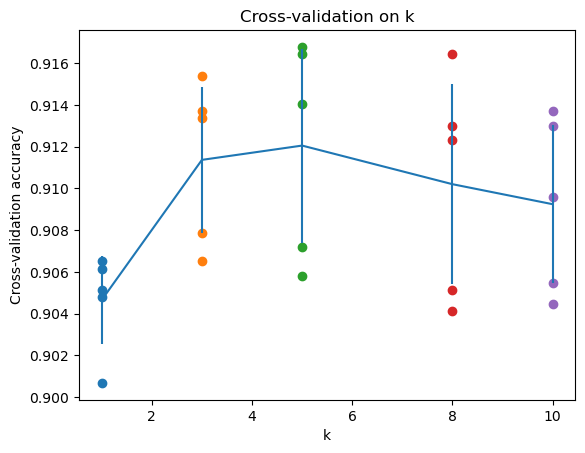

In [78]:
# 绘制原始观察结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 用与标准偏差相对应的误差线绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

#### 选择最佳k值，使用全部训练数据训练分类器并测试

In [79]:
# 根据上述交叉验证结果，为k选择最佳值，使用所有训练数据重新训练分类器，
# 并在测试中对其进行测试数据。
best_k = k_choices[accuracies_mean.argmax()]
print('best_k = ',best_k)
clf = KNearestNeighbor()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))

best_k =  5
Got 7807 / 10000 correct => accuracy: 0.780700


### 3.2 Softmax (15 points)

#### 3.2.1 处理数据集，从训练集再次划分出验证集，用于最优模型保存

In [36]:
# 验证集比例
valid_rate = 0.3

data_num = X_train.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')

#### 3.2.2 定义模型、损失函数、优化器、评价指标、绘图函数、封装好的用于训练测试的Runner类

In [37]:
from fudanPRML.linear_model.softmax import SoftmaxClassifier
from fudanPRML.linear_model.criterion import MultiCrossEntropyLoss
from fudanPRML.linear_model.optimizer import SimpleBatchGD
from fudanPRML.linear_model.metric import accuracy
from fudanPRML.linear_model.plot import plot
from fudanPRML.linear_model.runner import RunnerV2

#### 3.2.3 设置参数，实例化模型

In [52]:
init_lr = 0.05
num_epochs = 1000
log_epochs = 10

model = SoftmaxClassifier(input_dim = 784 ,output_dim = 10)
metric = accuracy
criterion = MultiCrossEntropyLoss()
optimizer = SimpleBatchGD(init_lr=init_lr,model=model)
# 实例化RunnerV2
runner = RunnerV2(model, optimizer, metric, criterion)

#### 3.2.4 启动训练

In [53]:
runner.train([X_train_set, y_train_set], [X_valid_set, y_valid_set], num_epochs = num_epochs, log_epochs = log_epochs, save_path="best_model.pdparams")

best accuracy performence has been updated: 0.00000 --> 0.42146
[Train] epoch: 0, loss: 2.302591562271118, score: 0.40645793080329895
[Dev] epoch: 0, loss: 2.039687395095825, score: 0.42146119475364685
best accuracy performence has been updated: 0.42146 --> 0.42329
best accuracy performence has been updated: 0.42329 --> 0.73470
best accuracy performence has been updated: 0.73470 --> 0.76507
[Train] epoch: 10, loss: 2.045391082763672, score: 0.41575342416763306
[Dev] epoch: 10, loss: 1.826904535293579, score: 0.6342465877532959
best accuracy performence has been updated: 0.76507 --> 0.77123
best accuracy performence has been updated: 0.77123 --> 0.80205
best accuracy performence has been updated: 0.80205 --> 0.81895
best accuracy performence has been updated: 0.81895 --> 0.82511
[Train] epoch: 20, loss: 1.6515885591506958, score: 0.8095890283584595
[Dev] epoch: 20, loss: 1.6360368728637695, score: 0.8251141309738159
best accuracy performence has been updated: 0.82511 --> 0.82580
best ac

#### 3.2.6 绘制图像

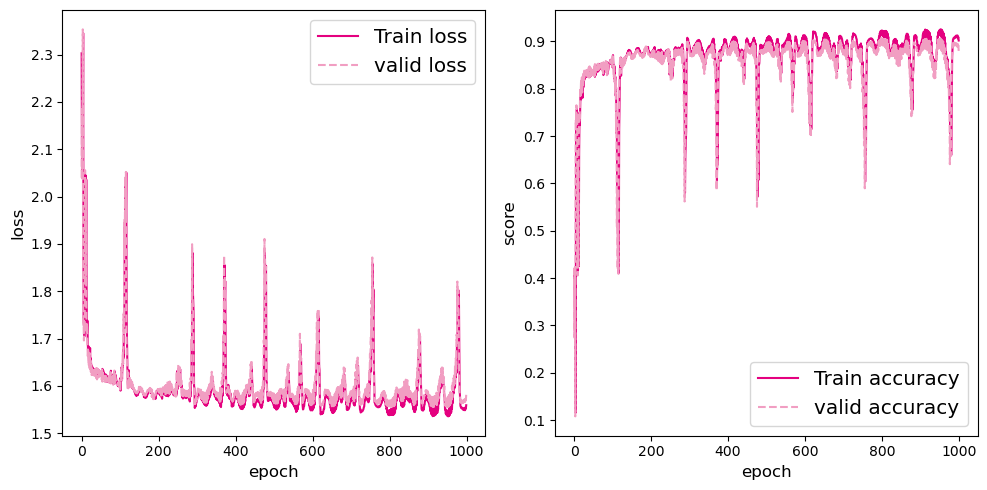

In [54]:
# 绘制训练过程中loss下降图像

plot(runner,fig_name='softmax_classifier.pdf')

#### 3.2.7 在测试集上评估模型

In [56]:
# 使用测试集评估模型

# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate([X_test_set, y_test_set])
print(f'[Test Dataset]: accuracy:{score}, loss: {loss}')

[Test Dataset]: accuracy:0.7421000003814697, loss: 1.7190816402435303


#### 3.2.8 一些感受与分析


##### 关于使用验证集的问题：

类别不均衡问题仍然影响很大，在测试集上效果相当不好，使用验证集保存最优参数的方法，事实上也逐渐使得模型拟合在了验证集上

然而，我们应该注意到，本身测试集类别不均衡，验证集中更可能出现某些类别数量极其小的情况，因此反而效果更差。

##### 关于优化器和梯度下降过程：

一开始使用了lr = 0.1 的整批常规梯度下降方法，在训练到接近100轮epoch时，loss出现激增。分析原因，应该是在训练后期学习率过大所致，后续可以采用学习率衰减的方法

### 3.3 Neural Network (30 points)

#### 3.3.1 数据集构建
直接使用 3.2.1 中划分好的数据集，在此不再重复

In [58]:
# 验证集比例
valid_rate = 0.3

data_num = X_train.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')

#### 3.3.2 定义模型、损失函数、优化器、评价指标、以及封装好的Runner类

In [59]:
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.mlp import Model_MLP_L5
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import BatchGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV2_1

#### 3.3.3 开始训练

In [60]:
epoch_num = 1000

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 这是一个5层神经网络
# model = Model_MLP_L5(input_size=input_size,output_size=output_size)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.1
optimizer = BatchGD(learning_rate, model)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV2_1(model, optimizer, metric, loss_fn)

runner.train([X_train_set, y_train_set], [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)

前向计算时间 0.19770210000024235 second
计算交叉熵损失时间 0.1169277000008151 second
反向传播时间 0.3455813999989914 second
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.05548
[Train] epoch: 1/1000, loss: 24.651905059814453
本轮epoch训练时间: 0.7782644000017171 second
前向计算时间 0.20085519999884127 second
计算交叉熵损失时间 0.10297159999936412 second
反向传播时间 0.34896589999880234 second
[Evaluate] best accuracy performence has been updated: 0.05548 --> 0.14110
[Train] epoch: 2/1000, loss: 16.539268493652344
本轮epoch训练时间: 0.7730401000007987 second
前向计算时间 0.1987778000002436 second
计算交叉熵损失时间 0.10634299999946961 second
反向传播时间 0.3553618000005372 second
[Evaluate] best accuracy performence has been updated: 0.14110 --> 0.19726
[Train] epoch: 3/1000, loss: 11.901503562927246
本轮epoch训练时间: 0.7736581999997725 second
前向计算时间 0.20758649999879708 second
计算交叉熵损失时间 0.11056149999967602 second
反向传播时间 0.35591960000056133 second
[Evaluate] best accuracy performence has been updated: 0.19726 --> 0.32352
[Train] epoch: 4/1000, 

#### 3.3.4 绘制图像

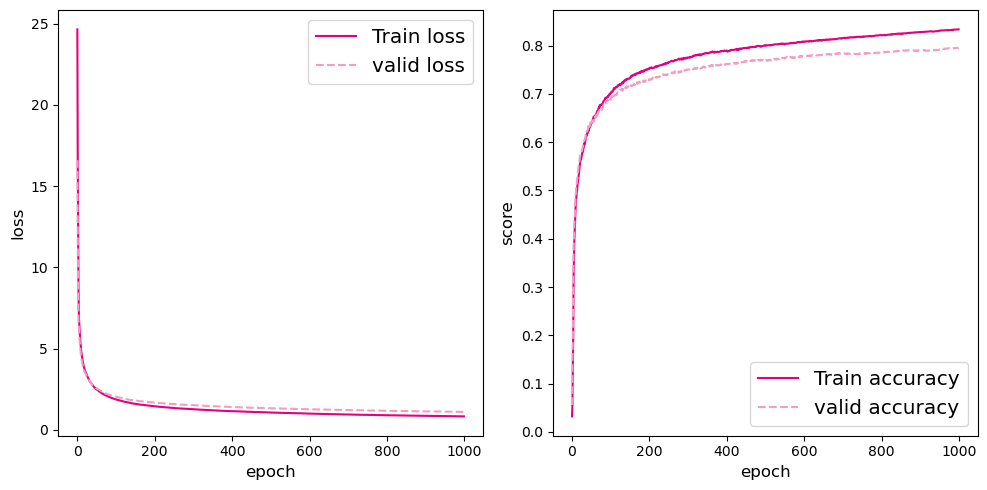

In [61]:
# 打印训练集和验证集的损失 
from fudanPRML.neural_network.plot import plot
plot(runner,fig_name='nnfigure')

#### 3.3.5 在测试集上评估模型

In [62]:
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])

print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.5035/3.6166


### 3.4 Your Exploration (30 points)

#### 3.4.1 更多层的前馈神经网络架构
本任务中默认要求完成一个MLP_L2，即一个两层的前馈神经网络。

而一般来说，在达到同样的测试效果时，深层网络会比浅层网络需要更少的参数量。

因此，我使用一个5层的前馈神经网络，其架构为：(784,512),(512,256),(256,128),(128,64),(64,10)

使用此网络，我在MNIST手写数字识别数据集上训练，可以达到95%的准确率，因此在此网络中同样进行尝试。

后续的探索，也会使用这个MLP_L5的架构

In [ ]:

from fudanPRML.neural_network.mlp import Model_MLP_L5

#### 3.4.2 解决类别不均衡问题
类别不均衡的问题会对数据训练过程产生很大影响，在多分类问题中又称为“长尾”问题，进行预测类别时，分类器将有预测训练数据中数量最多的类别的趋势，这可以在训练中达到极高的准确率。

然而，我们往往关心的是分类器在测试数据集中，对任何一类数据预测的表现，即使它的数量很少

最常见的方法，是对数据集直接进行处理，这其中，一般有 过采样(重采样)，欠采样 两种方法，因采样存在丢弃训练数据的情况，容易造成欠拟合，因此又以过采样应用为多。


##### 3.4.2.1 简单随机过采样 (Naive random over-sampling)
 The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
np.random.seed(1024)
ros = RandomOverSampler(random_state=0)
X_train_resampled,y_train_resampled = ros.fit_resample(X_train,y_train)
print('当前各类别数量',sorted(Counter(y_train_resampled).items()))

# 一定要再次打乱! 重取样后返回的类别非常不均匀！如果不打乱，划分验证集会出现很大问题！从而影响训练中模型选择
paddle.seed(1024)
idx = paddle.randperm(X_train_resampled.shape[0])
X_train_resampled = X_train_resampled[idx]
y_train_resampled = y_train_resampled[idx]

# 验证集比例
valid_rate = 0.3
data_num = X_train_resampled.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train_resampled[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train_resampled[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train_resampled[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train_resampled[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')


当前各类别数量 [(0, 6000), (1, 6000), (2, 6000), (3, 6000), (4, 6000), (5, 6000), (6, 6000), (7, 6000), (8, 6000), (9, 6000)]


In [ ]:
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
clf = KNearestNeighbor()
clf.fit(X_train_resampled, y_train_resampled)
y_test_pred = clf.predict(X_test, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))


Got 1000 / 10000 correct => accuracy: 0.100000


In [ ]:
from fudanPRML.neural_network.mlp import Model_MLP_L5
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import BatchGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV2_1



epoch_num = 3000

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# model = Model_MLP_L5(input_size=input_size,output_size=output_size)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.1
optimizer = BatchGD(learning_rate, model)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV2_1(model, optimizer, metric, loss_fn)

runner.train([X_train_set, y_train_set], [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


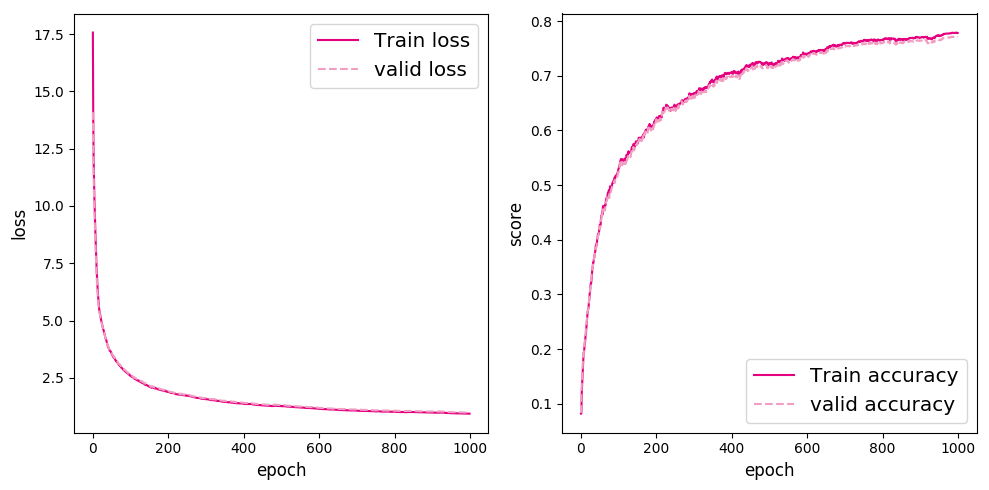

In [ ]:
# 打印训练集和验证集的损失 
from fudanPRML.neural_network.plot import plot
plot(runner,fig_name='nnfigure')

In [ ]:
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])

print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.6318/1.9145


##### 3.4.2.2 SMOTE算法
SMOTE是基于KNN的一种简单的插值算法

In [67]:
from imblearn.over_sampling import SMOTE
from collections import Counter
np.random.seed(1012)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print('当前各类别数量',sorted(Counter(y_train_resampled).items()))

paddle.seed(1024)
idx = paddle.randperm(X_train_resampled.shape[0])
X_train_resampled = X_train_resampled[idx]
y_train_resampled = y_train_resampled[idx]

# 验证集比例
valid_rate = 0.3
data_num = X_train_resampled.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train_resampled[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train_resampled[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train_resampled[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train_resampled[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')

当前各类别数量 [(0, 6000), (1, 6000), (2, 6000), (3, 6000), (4, 6000), (5, 6000), (6, 6000), (7, 6000), (8, 6000), (9, 6000)]


In [ ]:
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
clf = KNearestNeighbor()
clf.fit(X_train_resampled, y_train_resampled)
y_test_pred = clf.predict(X_test, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))

Got 1000 / 10000 correct => accuracy: 0.100000


In [68]:
from fudanPRML.neural_network.mlp import Model_MLP_L5
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import BatchGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV2_1
epoch_num = 3000

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 这是一个5层神经网络
# model = Model_MLP_L5(input_size=input_size,output_size=output_size)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.1
optimizer = BatchGD(learning_rate, model)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV2_1(model, optimizer, metric, loss_fn)

runner.train([X_train_set, y_train_set], [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)


[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.08961
[Train] epoch: 1/1000, loss: 14.982928276062012
[Train] epoch: 2/1000, loss: 13.081925392150879
[Train] epoch: 3/1000, loss: 11.801338195800781
[Train] epoch: 4/1000, loss: 10.83508586883545
[Evaluate] best accuracy performence has been updated: 0.08961 --> 0.09222
[Train] epoch: 5/1000, loss: 10.109292030334473
[Evaluate] best accuracy performence has been updated: 0.09222 --> 0.09889
[Train] epoch: 6/1000, loss: 9.574820518493652


KeyboardInterrupt: 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


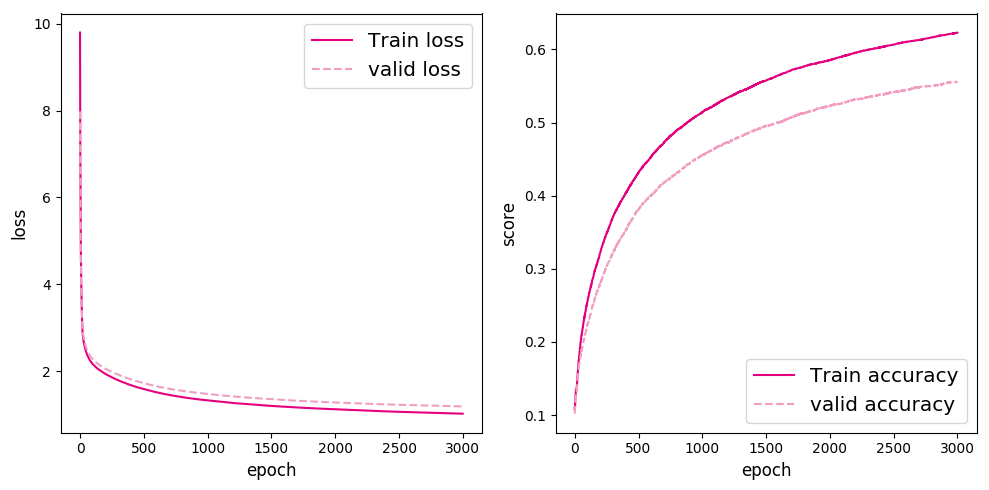

In [20]:
# 打印训练集和验证集的损失 
from fudanPRML.neural_network.plot import plot
plot(runner,fig_name='nnfigure')

In [21]:
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])

print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.6236/1.0239


#### 3.4.2 不同激活函数的影响

#### 3.4.3 不同优化器的影响

## 4. Conclusion (5 points)

## Reference
List your references here.

[1] Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv: https://arxiv.org/abs/1708.07747, GitHub: https://github.com/zalandoresearch/fashion-mnist

[2] 解决softmax交叉熵损失的溢出问题的方法 https://blog.csdn.net/muyuu/article/details/122757470

[3] softmax交叉熵损失函数的求导 https://blog.csdn.net/xiaocong1990/article/details/82464069/